In [15]:
from matplotlib import pyplot as plt
import numpy as np
from netCDF4 import Dataset
import netCDF4
import cartopy.crs as ccrs
import cartopy
import matplotlib.path as mpath
import pandas as pd
import pickle
import gsw
import cftime
import datetime
from scipy import ndimage
from mpl_toolkits import mplot3d
from matplotlib import cm
import matplotlib.patches as mpatches
import cmocean
from cartopy.feature import NaturalEarthFeature
import cmocean
import seaborn as sns
import matplotlib.ticker as mtick



SMALL_SIZE = 18
MEDIUM_SIZE = 24
BIGGER_SIZE = 28
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [2]:
#constant
path='/storage/jlavoie/Research/Data/Budget/'
fTEMP=Dataset(path+'b.e11.BRCP85C5CNBDRD.f09_g16.002.pop.h.TEMP.200601-208012.nc')
fTEMP1=Dataset(path+'b.e11.B20TRC5CNBDRD.f09_g16.002.pop.h.TEMP.192001-200512.nc')
faice=Dataset(path+'b.e11.BRCP85C5CNBDRD.f09_g16.002.cice.h.aice_nh.200601-208012.nc')

months=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
nbDaysInMonth=[31,28,31,30,31,30,31,31,30,31,30,31]

rho_sw=fTEMP['rho_sw'][:]*1000#kg m-3
cp_sw=fTEMP['cp_sw'][:]*0.0001#J kg-1 K-1
T2E=rho_sw*cp_sw#J degC-1 m-3

latent_heat_vapor=fTEMP['latent_heat_vapor'][:]
latent_heat_fusion=fTEMP1['latent_heat_fusion'][:]*1e-7*1000# erg/g -> J/kg
rho_ice=917#kg/m3

dz=fTEMP['dz'][:]*0.01# m
dzw=fTEMP['dzw'][:]*0.01# m
Tf=-1.8
tlong=fTEMP['TLONG'][:]
tlat=fTEMP['TLAT'][:]
tlon=faice['TLON'][:]
tla=faice['TLAT'][:]
z_t=fTEMP['z_t'][:]*0.01#m
z_w=fTEMP['z_w'][:]*0.01#m
z_w_top=fTEMP['z_w_top'][:]*0.01#m
z_w_bot=fTEMP['z_w_bot'][:]*0.01#m


timeDay1=fTEMP1['time']
Jan1920=cftime.DatetimeNoLeap(1920, 1, 1, 0, 0, 0, 0, 0, 0)
time1 = netCDF4.num2date(timeDay1[:],timeDay1.units,calendar=timeDay1.calendar)
time1=[Jan1920]+list(time1[:-1])
time_boundDay1=fTEMP1['time_bound']
time_bound1 = netCDF4.num2date(time_boundDay1[:],timeDay1.units,calendar=timeDay1.calendar)
ind1970, ind1980= 600,720

timeDay=fTEMP['time']
time = netCDF4.num2date(timeDay[:],timeDay.units,calendar=timeDay.calendar)
#fix month error in cesm
Jan2006=cftime.DatetimeNoLeap(2006, 1, 1, 0, 0, 0, 0, 0, 0)
time=[Jan2006]+list(time[:-1])
time_boundDay=fTEMP['time_bound']
time_bound = netCDF4.num2date(time_boundDay[:],timeDay.units,calendar=timeDay.calendar)
ind2010=12*4
ind2020=12*14




# create mask CB
maskCBocn=np.zeros((384,320))
for i in range(384):
    for j in range(320):
        if  205<=tlong[i,j]<=230 and 72<=tlat[i,j]<=80:
            maskCBocn[i,j]=1
            
maskCBice=np.zeros((104,320))
for i in range(104):
    for j in range(320):
        if  205<=tlon[i,j]<=230 and 72<=tla[i,j]<=80:
            maskCBice[i,j]=1


pathSaved='/storage/jlavoie/Research/Data/saved/'
with open(pathSaved+"ajProfiles.txt", "rb") as fp:  
    ajProfiles=pickle.load(fp)
print('ajloaded!')
with open(pathSaved+"itpProfiles.txt", "rb") as fp:  
    itpProfiles=pickle.load(fp)
print('itploaded!')
z_O=ajProfiles[0]['D']


ajloaded!
itploaded!


# domain

In [3]:
pathBath='/storage/jlavoie/Research/Data/'
fbath=Dataset(pathBath+'ETOPO2v2c_f4.nc')
fbath

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Conventions: COARDS
    title: 
    source:                         -Rd -I2m -ZTLf                          
    node_offset: 1
    dimensions(sizes): x(10800), y(5400)
    variables(dimensions): float32 x(x), float32 y(y), float32 z(y,x)
    groups: 

/aos/home/jlavoie/.conda/envs/a/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


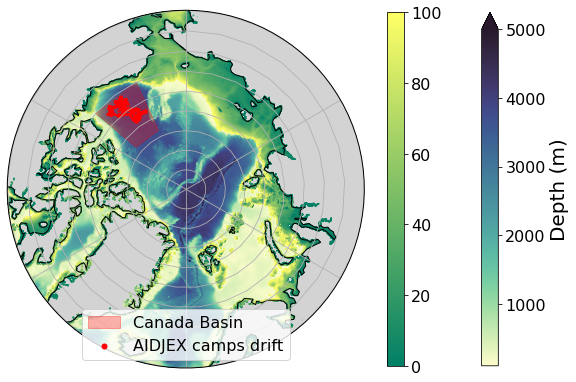

In [14]:
fig = plt.figure(figsize=[10,10])
ax = plt.subplot( projection=ccrs.NorthPolarStereo())
ax.gridlines()
ax.set_extent([-180, 180,63, 90], ccrs.PlateCarree())
ax.add_feature(cartopy.feature.COASTLINE)
ax.set_boundary(circle, transform=ax.transAxes)
X,Y=np.meshgrid(fbath['x'],fbath['y'][3000:])
data=-fbath['z'][3000:]
data[data<0]=np.nan



scat=ax.scatter(X,Y,c=data,cmap=cmocean.cm.deep,marker='.',s=0.1,transform= ccrs.PlateCarree(),
           label='AIDJEX camps drift',vmax=5000,vmin=100)
c1=plt.colorbar(scat,extend='max', shrink=0.65)
dataShallow=data.copy()
dataShallow[dataShallow>100]=np.nan
scat1=ax.scatter(X,Y,c=dataShallow,cmap='summer',marker='.',s=0.1,transform= ccrs.PlateCarree(),
           vmax=100,vmin=0)
c2=plt.colorbar(scat1, shrink=0.65)
c1.set_label('Depth (m)')
#add a title
# use a better cmap https://matplotlib.org/cmocean/

#drift of aidjex camp
for pro in ajProfiles: 
    if pro['lat']!= 99.9999:
        scat=ax.scatter(pro['lon'],pro['lat'],c='red',marker='.',s=5,transform= ccrs.PlateCarree(), label='AIDJEX camps drift')

ax.add_patch(mpatches.Rectangle(xy=[205, 72], width=25, height=8,
                                    facecolor='red', edgecolor='red',
                                    alpha=0.3,
                                    transform=ccrs.PlateCarree(), label='Canada Basin')
                                    #transform=ccrs.Geodetic())
                 )

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
lgnd=plt.legend(by_label.values(), by_label.keys(), loc='lower center')
lgnd.legendHandles[1]._sizes = [100]


"""
#ax.text(233,71.5,'Beaufort Sea',rotation=38,color='black',transform= ccrs.PlateCarree(),fontsize=13)
ax.text(198,72,'Chukchi \n    Sea',rotation=10,color='black',transform= ccrs.PlateCarree(),fontsize=13)
#ax.text(225,79,'CB',rotation=35,color='red',transform= ccrs.PlateCarree(),fontsize=15)
ax.text(216.5,68.5,'Point Barrow',rotation=-35,color='black',transform= ccrs.PlateCarree(),fontsize=10)
ax.text(196,66.8,'Bering \n \n  Strait',rotation=0,color='black',transform= ccrs.PlateCarree(),fontsize=10)
ax.text(350,79,'Fram \n Strait',rotation=-15,color='black',transform= ccrs.PlateCarree(),fontsize=10)
ax.text(30,78,'Barent Sea \n Opening',rotation=25,color='black',transform= ccrs.PlateCarree(),fontsize=10)
"""
ax.add_feature(cartopy.feature.LAND,color='lightgray')


In [24]:
test=[pro for pro in itpProfiles if pro['sic']>=0.60]
len(test)

14184

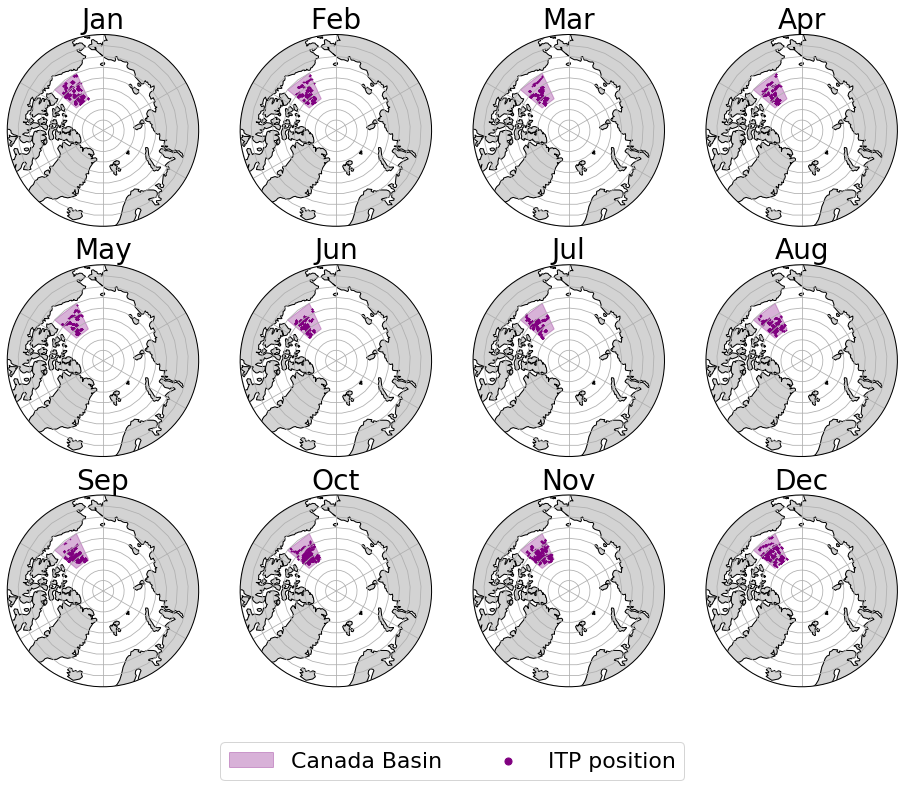

In [31]:
#verify distribution of itp
nbPro=[0,0,0,0,0,0,0,0,0,0,0,0]
fig=plt.figure(figsize=(16,12))
for m in range(1,13):
    ax1 = plt.subplot(3,4,m, projection=ccrs.NorthPolarStereo())
    #axs = plt.subplots( projection=ccrs.NorthPolarStereo())
    ax1.gridlines()
    ax1.set_extent([-180, 180,63, 90], ccrs.PlateCarree())
    ax1.add_feature(cartopy.feature.COASTLINE)
    ax1.set_boundary(circle, transform=ax1.transAxes)

    #drift of aidjex camp
    for pro in itpProfiles: 
        if pro['lat']!= 99.9999 and pro['month']==m:
            nbPro[m-1]+=1
            ax1.scatter(pro['lon'],pro['lat'],c='purple',marker='.',s=1,transform= ccrs.PlateCarree(), label='ITP position')

    ax1.add_patch(mpatches.Rectangle(xy=[205, 72], width=25, height=8,
                                    facecolor='purple', edgecolor='purple',
                                    alpha=0.3,
                                    transform=ccrs.PlateCarree(), label='Canada Basin')
                                    #transform=ccrs.Geodetic())
                 )
    ax1.add_feature(cartopy.feature.LAND,color='lightgray')
    ax1.set_title(months[m-1])

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
lgnd =fig.legend(by_label.values(), by_label.keys(), loc='lower center', ncol=2, fontsize=22)
lgnd.legendHandles[1]._sizes = [200]

# T vs SIC

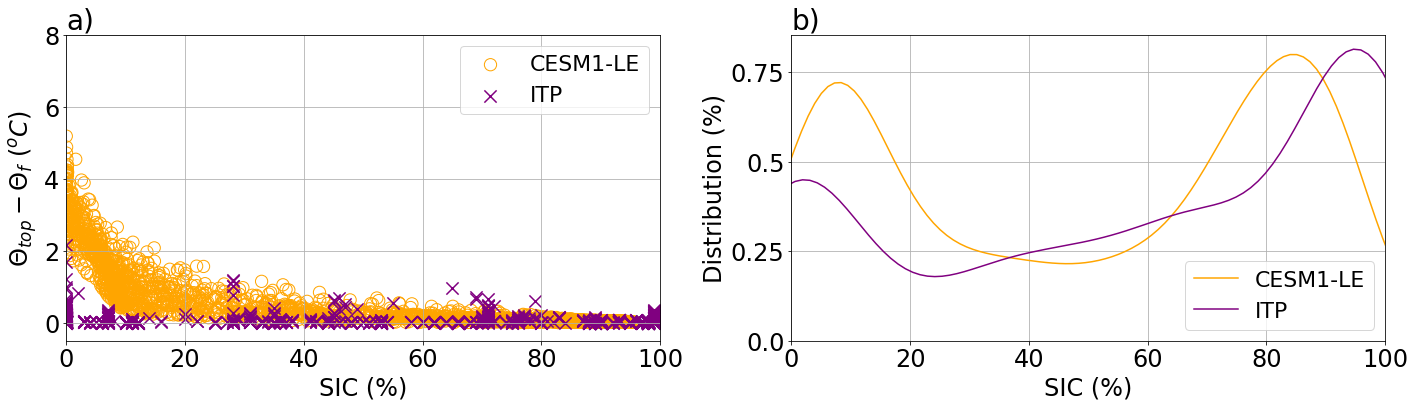

In [28]:
# t surface vs sic for september
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
m=8
#aiceCB=np.array([faice['aice'][ind2010+m:ind2020+m:12][:,maskCBice==1] for m in range(12)])
#TEMPCB=np.array([fTEMP['TEMP'][ind2010+m:ind2020+m:12][:,:,maskCBocn==1] for m in range(12)])
ax1.scatter(aiceCB[m].ravel(),TEMPCB[m,:,0].ravel()--1.8,marker='o',
            s=150,edgecolors='orange',label='CESM1-LE',facecolors='none',)
ax1.set_xlabel('SIC (%)')
ax1.set_ylabel('$\Theta_{top} -\Theta_f$ ($^oC$)')
ax1.grid()
ax2.grid()
ax1.set_xlim(0,100)
ax1.set_ylim(-0.5,8)
label=True
for pro in itpProfiles:
    if pro['month']==9:
        ax1.scatter(pro['sic']*100,(pro['T']-gsw.pt_from_CT(pro['S'],gsw.CT_freezing(pro['S'],z_O,1)))[10],
                    marker='x', s=150,color='purple',label='ITP' if label else None)
        label=False
sns.distplot(aiceCB[8].ravel(),label='CESM1-LE',color='orange',ax=ax2,hist=False)
sns.distplot([pro['sic']*100 for pro in itpProfiles if pro['month']==9],label='ITP',color='purple',ax=ax2
            ,hist=False)

ax2.set_yticklabels(['0.0', '0.25', '0.5', '0.75', '1.0', '1.25', '1.5', '1.75'])
ax2.set_ylabel('Distribution (%)')
ax2.set_xlim(0,100)
ax2.set_xlabel('SIC (%)')
ax1.legend(fontsize=22)
ax2.legend(fontsize=22)
ax1.tick_params(axis='both', labelsize=24)
ax2.tick_params(axis='both', labelsize=24)
ax1.set_title('a)', loc='left')
ax2.set_title('b)', loc='left')
plt.tight_layout()

# 3D individual instruments

/aos/home/jlavoie/.conda/envs/a/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/aos/home/jlavoie/.conda/envs/a/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


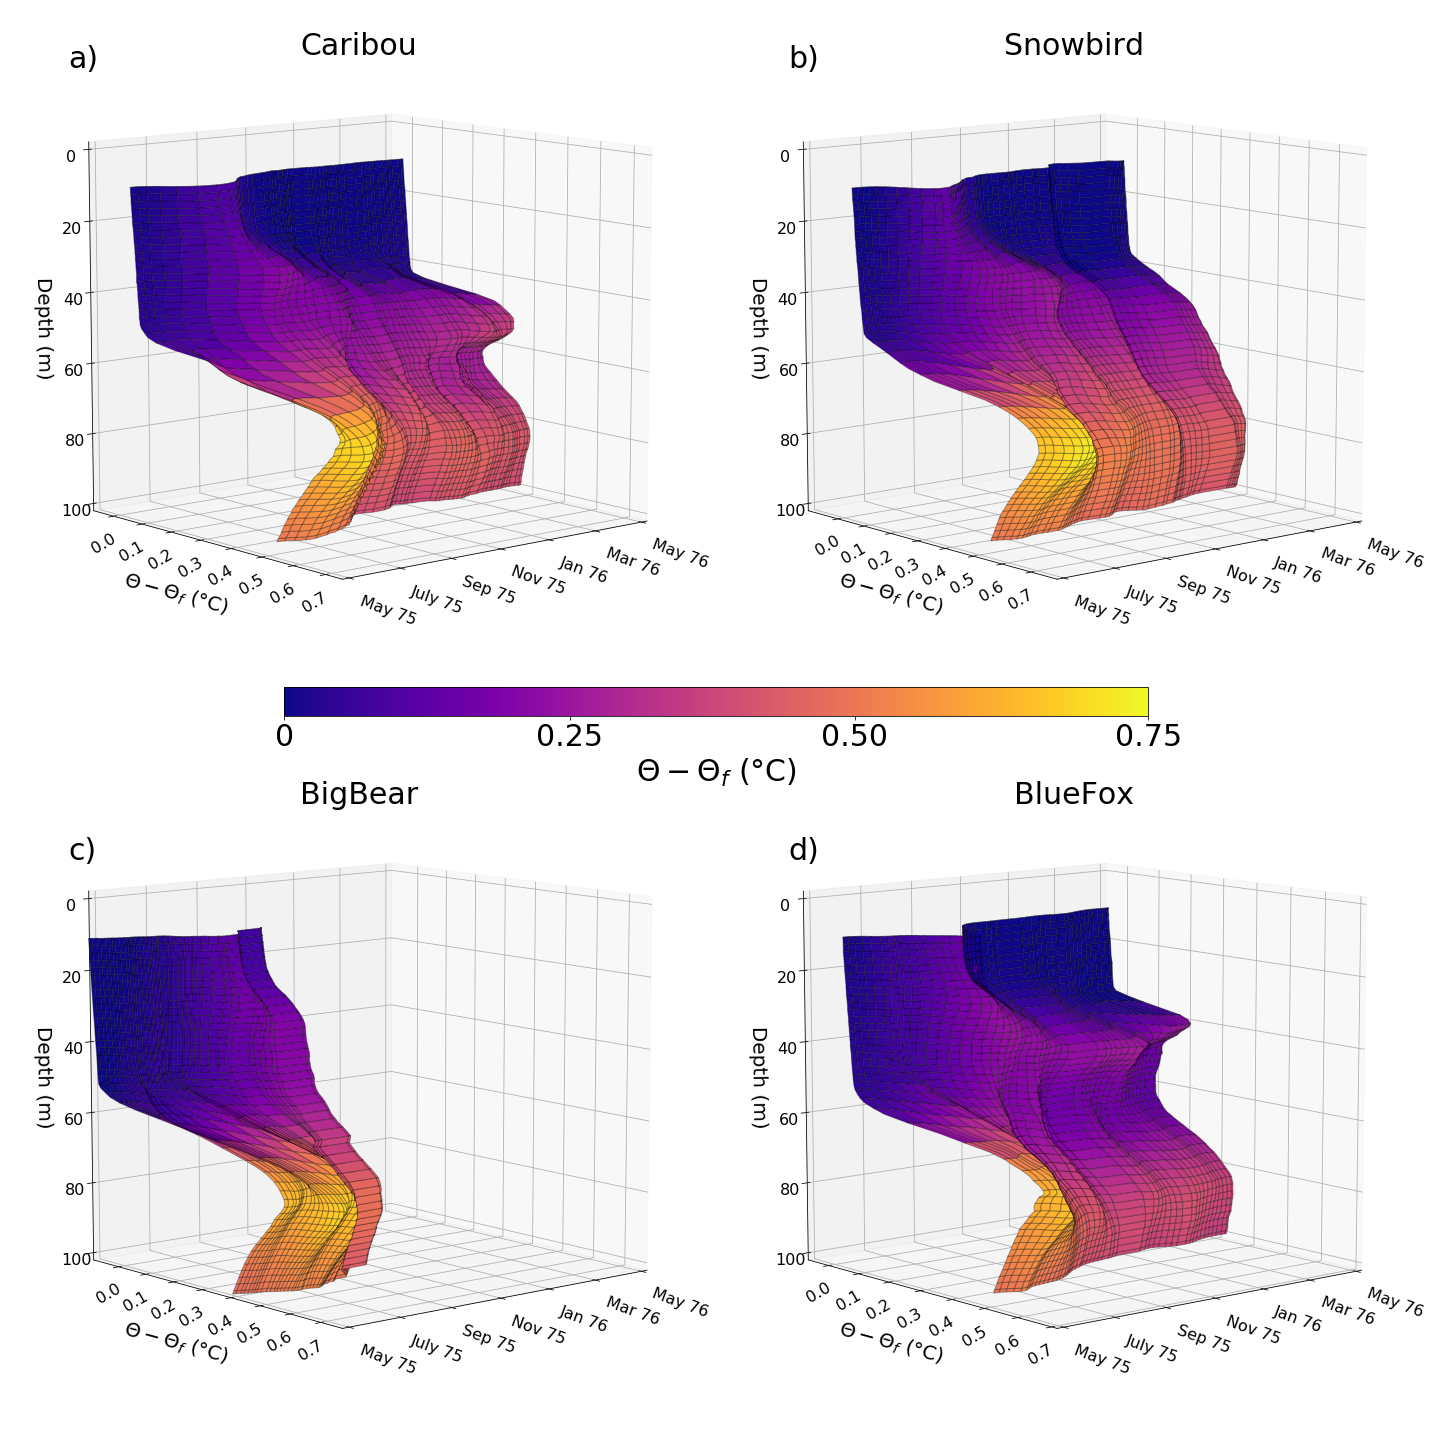

In [3]:
#4 camps with z axis depth
camps=['Caribou','Snowbird','BigBear','BlueFox']
letter=['a)','b)','c)','d)']
#define xticks
xtickdt=[datetime.date(1975,5,1),datetime.date(1975,7,1),datetime.date(1975,9,1),datetime.date(1975,11,1),
              datetime.date(1976,1,1),datetime.date(1976,3,1),datetime.date(1976,5,1)]
xtickPos=[pd.Timestamp(x).to_julian_date() for x in xtickdt]
xtickLab=['May 75','July 75','Sep 75','Nov 75','Jan 76','Mar 76', 'May 76']
fig = plt.figure(figsize=(20,20))
for nCamp in range(4):
    # get date, and delta T for snowbird
    datesSB=np.array([pro['datetime'] for pro in ajProfiles if pro['camp']==camps[nCamp] ])
    dTSB=np.array([pro['PT']-gsw.pt_from_CT(pro['S'],gsw.CT_freezing(pro['S'],z_O,1)) for pro in ajProfiles if pro['camp']==camps[nCamp]])
    # sort
    arr1inds = datesSB.argsort()
    datesSBs = datesSB[arr1inds]
    dTSBs = dTSB[arr1inds]
    #smooth
    smoothdTSBs=ndimage.gaussian_filter1d(dTSBs, 10, 0)
    
    # 3d vertical is temperature
    # put date in julian to be able to plot
    juliandatesSB=[pd.Timestamp(x).to_julian_date() for x in datesSBs]
    depth,time=np.meshgrid(z_O[:100],juliandatesSB)
    ax = fig.add_subplot(2, 2, nCamp+1, projection='3d')
    col=cm.plasma(smoothdTSBs[:,:100]/0.75)#0.73 is overall max
    cont=ax.plot_surface( time, smoothdTSBs[:,:100],depth,facecolors=col, cmap='plasma', edgecolor='k',linewidth=1)
    cont.set_edgecolor('#00000050')
    #ax.plot_wireframe( time, smoothdTSBs[:,:100],depth, color='black', alpha=0.5, linewidth=1, rstride=10, cstride=10)
    ax.set_zlabel('Depth (m)',labelpad=10)
    ax.set_ylabel(r'${\Theta -\Theta_f}$ (°C)',labelpad=20)
    ax.set_zlim(100,0)
    #plt.colorbar(cont)
    ax.invert_xaxis()# make date start in corner closest to use
    ax.view_init(10,50)# camera view#10,50
    # x tick with real date not julian
    plt.xticks(xtickPos,xtickLab,rotation=-20,ha='left');

    plt.yticks(rotation=30)
    ax.set_title(camps[nCamp],fontsize=30)
fig.text(0.05,0.95,'a)',fontsize=30)
fig.text(0.55,0.95,'b)',fontsize=30)
fig.text(0.05,0.40,'c)',fontsize=30)
fig.text(0.55,0.40,'d)',fontsize=30)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.2, 0.5, 0.6, 0.02])
cbar=fig.colorbar(cont, cax=cbar_ax,orientation='horizontal', ticks=[0,0.33,0.66,1])
cbar.ax.set_xticklabels(['0', '0.25','0.50' ,'0.75'],fontsize=30)
cbar.ax.set_xlabel(r'${\Theta -\Theta_f}$ (°C)',fontsize=30)
#fig.text(0.87,0.05,'Lavoie et al. (2021)',color='grey',fontsize=15)
plt.tight_layout(h_pad=8)

/aos/home/jlavoie/.conda/envs/a/lib/python3.7/site-packages/ipykernel_launcher.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


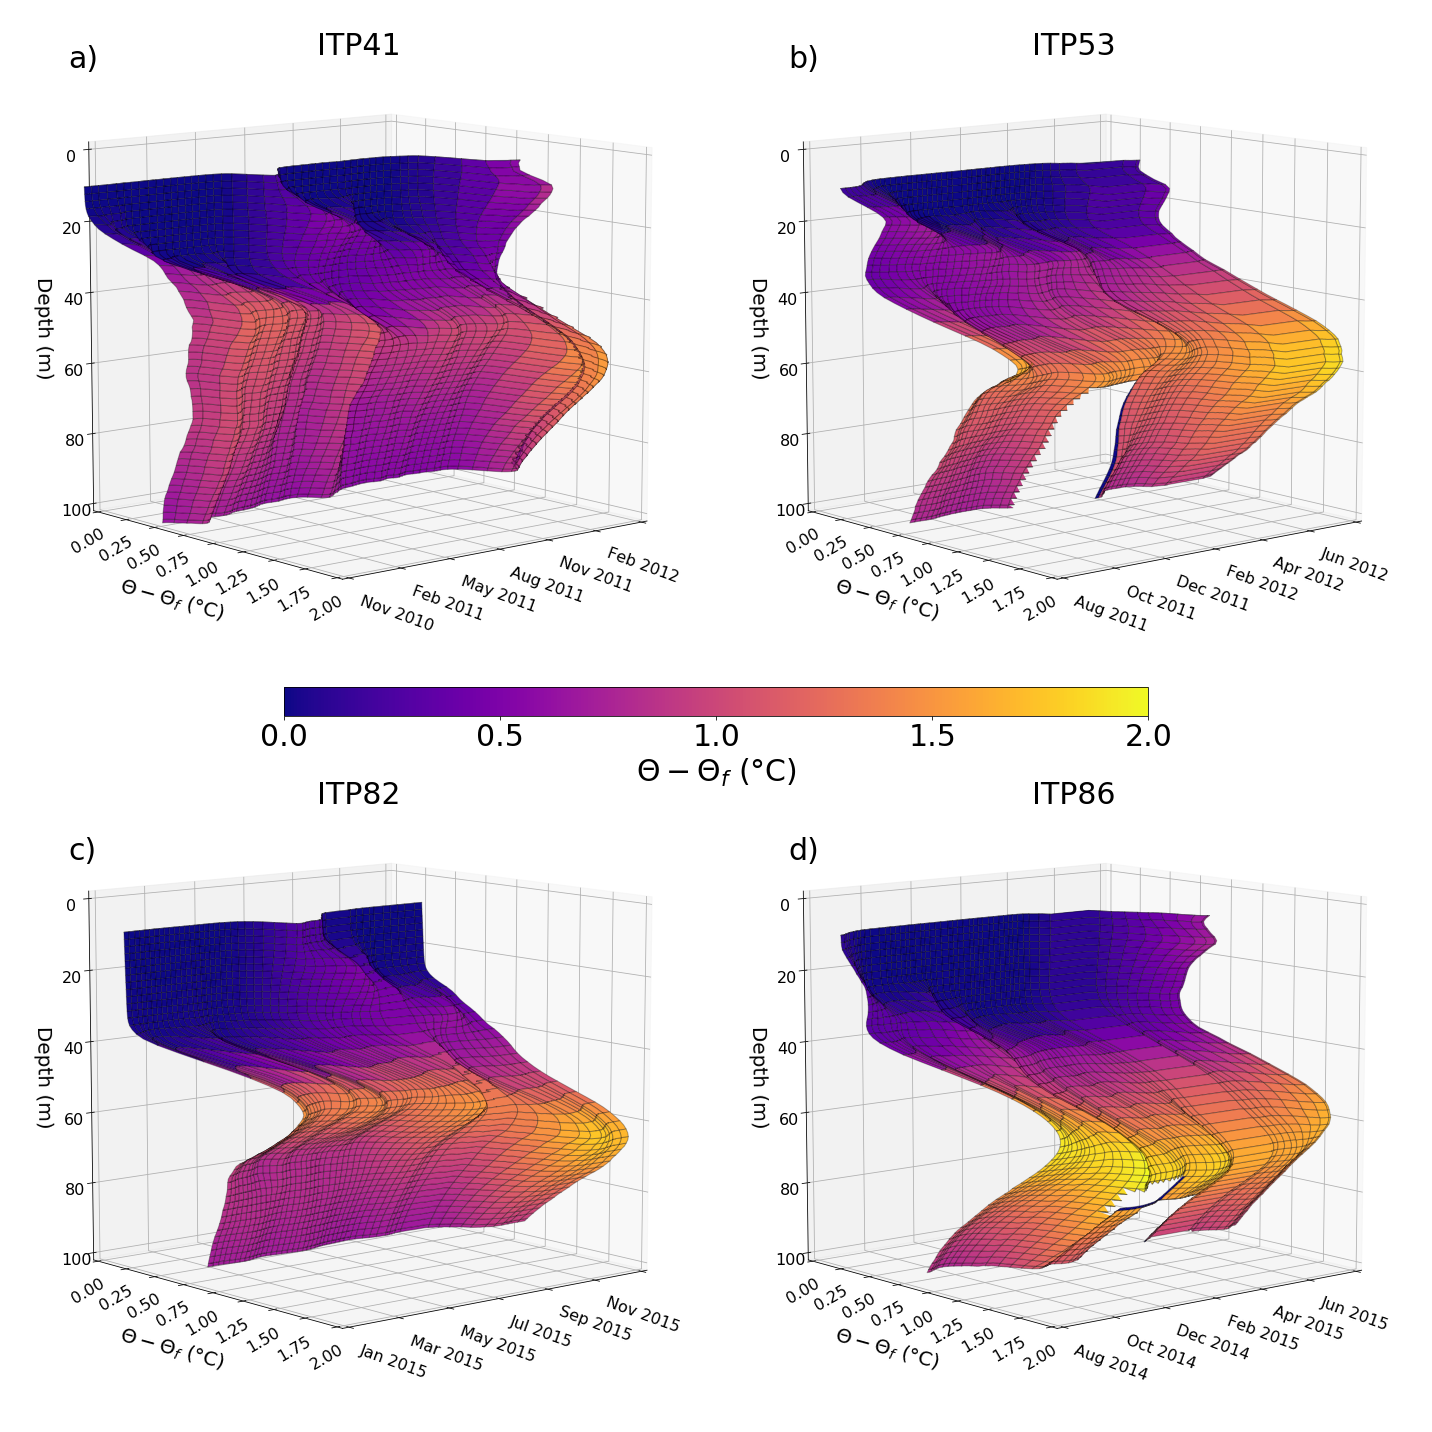

In [4]:
# individual itps
#4 itp with z axis depth

fig = plt.figure(figsize=(20,20))
count=1
for n in ['41','53','82','86']:
#for n in itpN:
    # get date, and delta T for snowbird
    datesITP=np.array([pro['datetime'] for pro in itpProfiles if pro['itp']==n ])
    dTITP=np.array([pro['PT']-gsw.pt_from_CT(pro['S'],gsw.CT_freezing(pro['S'],z_O,1)) for pro in itpProfiles if pro['itp']==n])
    # sort
    arr1inds = datesITP.argsort()
    datesITPs = datesITP[arr1inds]
    dTITPs = dTITP[arr1inds]
    #smooth
    smoothdTITPs=ndimage.gaussian_filter1d(dTITPs, 20, 0)
    
    # 3d vertical is temperature
    # put date in julian to be able to plot
    juliandatesITP=[pd.Timestamp(x).to_julian_date() for x in datesITPs]
    depth,time=np.meshgrid(z_O[:100],juliandatesITP)
    ax = fig.add_subplot(2,2, count, projection='3d')
    count+=1
    col=cm.plasma(smoothdTITPs[:,:100]/2)#2 is overall max
    cont=ax.plot_surface( time, smoothdTITPs[:,:100],depth,facecolors=col, cmap='plasma')
    cont.set_edgecolor('#00000050')
    #ax.plot_wireframe( time, smoothdTITPs[:,:100],depth, color='black', alpha=0.5, linewidth=1)
    ax.set_zlabel('Depth (m)',labelpad=10)
    ax.set_ylabel(r'${\Theta -\Theta_f}$ (°C)',labelpad=25)
    ax.set_zlim(100,0)
    ax.set_ylim(0,2)
    #plt.colorbar(cont)
    ax.invert_xaxis()# make date start in corner closest to use
    ax.view_init(10,50)# camera view
    # x tick with real date not julian
    #plt.xticks(juliandatesITP[::70],
               #[str(x.day)+ ' '+ months[x.month -1] +' '+str(x.year) for x in datesITPs[::70]],rotation=-20,ha='left');
    
    if n=='41':
        xtickdt=[datetime.date(2010,11,1),datetime.date(2011,2,1),datetime.date(2011,5,1),datetime.date(2011,8,1),
                  datetime.date(2011,11,1),datetime.date(2012,2,1),datetime.date(2012,5,1)]
    elif n=='53':
        xtickdt=[datetime.date(2011,8,1),datetime.date(2011,10,1),datetime.date(2011,12,1),datetime.date(2012,2,1),
                  datetime.date(2012,4,1),datetime.date(2012,6,1),datetime.date(2012,8,1)]
    elif n=='82':
        xtickdt=[datetime.date(2015,1,1),datetime.date(2015,3,1),datetime.date(2015,5,1),datetime.date(2015,7,1),
                  datetime.date(2015,9,1),datetime.date(2015,11,1),datetime.date(2016,1,1)]
    elif n=='86':
        xtickdt=[datetime.date(2014,8,1),datetime.date(2014,10,1),datetime.date(2014,12,1),datetime.date(2015,2,1),
                  datetime.date(2015,4,1),datetime.date(2015,6,1),datetime.date(2015,8,1)]
    xtickPos=[pd.Timestamp(x).to_julian_date() for x in xtickdt]
    xtickLab=[months[x.month -1] +' '+str(x.year) for x in xtickdt]
    plt.xticks(xtickPos,xtickLab[:-1]+[''],rotation=-20,ha='left');
    plt.yticks(rotation=30)
    ax.set_title('ITP'+n, fontsize=30)
fig.text(0.05,0.95,'a)',fontsize=30)
fig.text(0.55,0.95,'b)',fontsize=30)
fig.text(0.05,0.40,'c)',fontsize=30)
fig.text(0.55,0.40,'d)',fontsize=30)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.2, 0.5, 0.6, 0.02])
cbar=fig.colorbar(cont, cax=cbar_ax,orientation='horizontal', ticks=[0,0.25,0.5,0.75,1])
cbar.ax.set_xticklabels(['0.0', '0.5','1.0' ,'1.5','2.0'],fontsize=30)
cbar.ax.set_xlabel(r'${\Theta -\Theta_f}$ (°C)',fontsize=30)
#fig.text(0.87,0.03,'Lavoie et al. (2021)',color='grey',fontsize=15)
plt.tight_layout(h_pad=8)
plt.autoscale()

# sea ice cover - pacific centric retreat

In [3]:
pathCESM='/storage/jlavoie/Research/Data/CESM-LE/'

#list of string with numberof EM
EM=['00'+str(i) if i<10 else  '0'+str(i) if i<100 else ' '   for i in range(1,36)] +[str(i) for i in range(101,106)]


In [7]:
ind2030,ind2040=288, 408
time[ind2030],time[ind2040]

(cftime.DatetimeNoLeap(2030, 1, 1, 0, 0, 0, 0, 0, 1),
 cftime.DatetimeNoLeap(2040, 1, 1, 0, 0, 0, 0, 3, 1))

001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
101
102
103
104
105


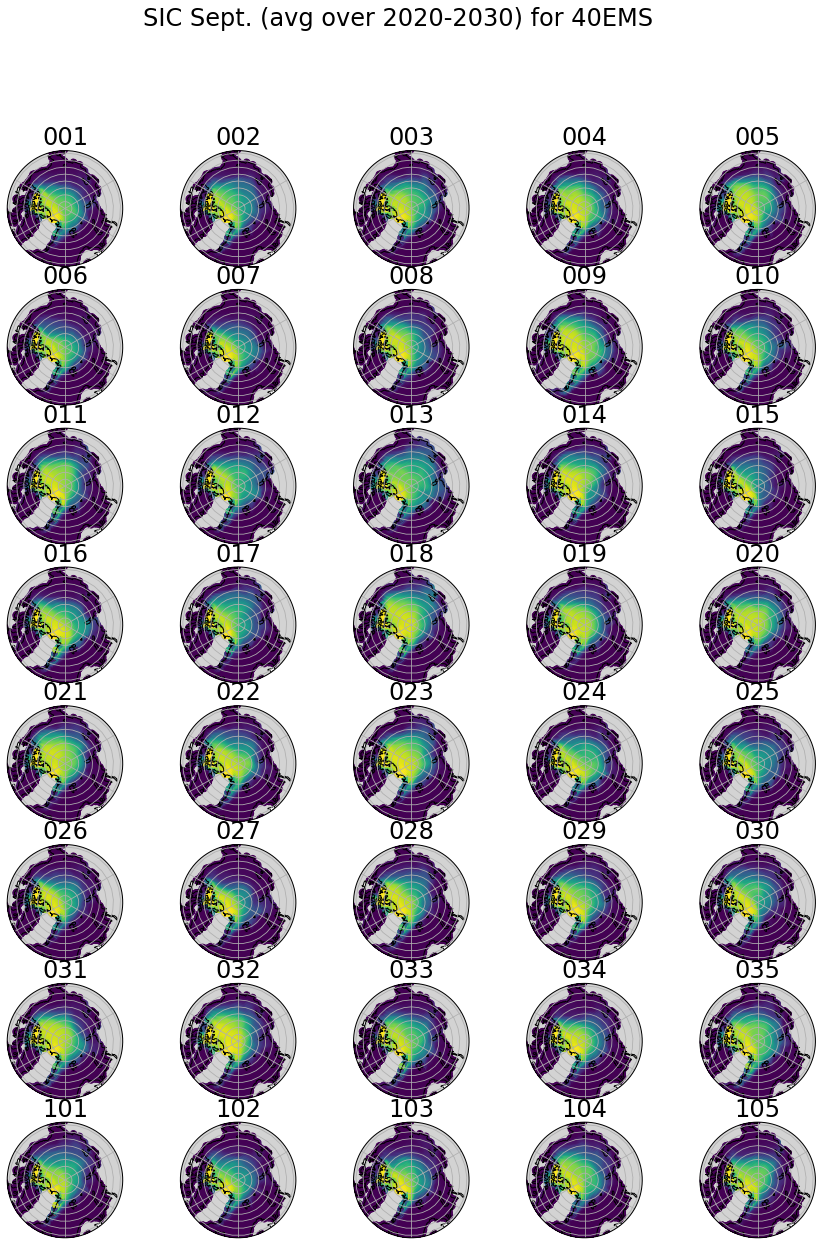

In [11]:
indA,indB=ind2020,ind2030
run='BRCP85C5CNBDRD'
model='cice'
var='aice'
varHemi=var+'_nh'#add hemisphere for name of file
#fig,axs = plt.subplots(5,8,figsize=[15,20])
axs=np.zeros((8,5))
fig=plt.figure(figsize=(15,20))
axsr=axs.ravel()
axsr=[0]*40
fig.suptitle("SIC Sept. (avg over 2020-2030) for 40EMS")
count=0
for em in EM:
    print(em)
    if int(em)>=34:
        date='200601-210012'
    else:
        date='200601-208012'
    fileEM=Dataset(pathCESM+var+'/b.e11.'+run+'.f09_g16.'+em+'.'+model+'.h.'+varHemi+'.'+date+'.nc')
    aice=fileEM[var][indA:indB]# cut like this because it is faster
    aiceSept=np.nanmean(aice[8::12],axis=0)
    ax=plt.subplot(8,5,count+1, projection=ccrs.NorthPolarStereo())
    

    
    #ax = plt.subplot( projection=ccrs.NorthPolarStereo())
    ax.set_extent([-180, 180,65, 90], ccrs.PlateCarree())
    ax.gridlines()
    ax.add_feature(cartopy.feature.COASTLINE)
    ax.set_boundary(circle, transform=ax.transAxes)
    scat=ax.scatter(tlon,tla,c=aiceSept, s=25,transform= ccrs.PlateCarree(),vmin=0, vmax=100)
    ax.add_feature(cartopy.feature.LAND,color='lightgray')
    #cb=plt.colorbar(scat)
    ax.set_title(em)
    count+=1

# ice and snow thickness

In [3]:
pathCESM='/storage/jlavoie/Research/Data/CESM-LE/'

#list of string with numberof EM
EM=['00'+str(i) if i<10 else  '0'+str(i) if i<100 else ' '   for i in range(1,36)] +[str(i) for i in range(101,106)]

#for each EM calculate all variables than take mean of all

#dictionnary where we store (40em,12 months) for each flux, before calculating mean and std

thick_40=[{'hi':[],'hs':[]},{'hi':[],'hs':[]}]
varByFlux={'hi':['hi'],'hs':['hs']}
thickMean=[]
thickStd=[]
thickMax=[]
thickMin=[]

for p in range(2):# iterate between 2 periods
    if p==0:
        indA,indB=ind1970,ind1980
        run='B20TRC5CNBDRD'
    else:
        indA,indB=ind2010,ind2020
        run='BRCP85C5CNBDRD'
    for em in EM: # iterate on each EM
        print(em)
        for f in thick_40[p]: # iterate through the fluxes we want to calculate
            varNeeded=[]
            for var in varByFlux[f]: # download the variables you need for the calculation of the flux f
                #specifics of filename
                model='pop'
                varHemi=var
                if var[0].islower():
                    model='cice'
                    varHemi=var+'_nh'#add hemisphere for name of file
                push1920=0
                if p==0:
                    if em=='001':
                        date='185001-200512'
                        push1920=840#push index to start at 1920 not 1850
                            
                    else:
                        date='192001-200512'          
                else:
                    if int(em)>=34 and p==1:
                        date='200601-210012'
                    else:
                        date='200601-208012'
                        
                fileEM=Dataset(pathCESM+var+'/b.e11.'+run+'.f09_g16.'+em+'.'+model+'.h.'+varHemi+'.'+date+'.nc')
                if em=='001':
                    varNeeded.append(fileEM[var][840:])
                else:
                    varNeeded.append(fileEM[var][:])


                dataVar_CB=np.nanmean([varNeeded[0][indA+m:indB+m:12][:,maskCBice==1]
                                                for m in range(12)],axis=(1,2))
                
            thick_40[p][f].append(dataVar_CB)

    for f in thick_40[p]:
        thick_40[p][f]=np.array(thick_40[p][f])


    # mean, std, min,max over the 40 ems
    meanB={}
    stdB={}
    maxB={}
    minB={}
    for f in thick_40[p]:
        meanB[f]=np.nanmean(thick_40[p][f],axis=0)
        stdB[f]=np.nanstd(thick_40[p][f],axis=0)
        maxB[f]=np.nanmax(thick_40[p][f],axis=0)
        minB[f]=np.nanmin(thick_40[p][f],axis=0)
    thickMean.append(meanB)
    thickStd.append(stdB)
    thickMax.append(maxB)
    thickMin.append(minB)


001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
101
102
103
104
105
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
101
102
103
104
105


In [4]:
thickMean[0]['hi'][6],thickMean[0]['hs'][6],thickMean[1]['hi'][6],thickMean[1]['hs'][6]

(3.624122, 0.13326398, 2.1582365, 0.021743774)

In [6]:
thickMean[0]['hi'][1],thickMean[0]['hs'][1],thickMean[1]['hi'][1],thickMean[1]['hs'][1]

(3.64548, 0.34593326, 2.3406804, 0.22586098)

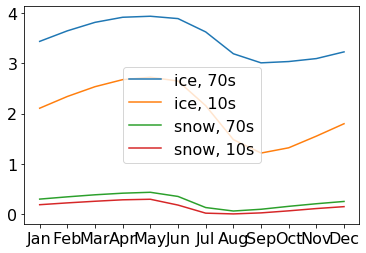

In [5]:
plt.plot(months,thickMean[0]['hi'],label='ice, 70s')
plt.plot(months,thickMean[1]['hi'],label='ice, 10s')
plt.plot(months,thickMean[0]['hs'],label='snow, 70s')
plt.plot(months,thickMean[1]['hs'],label='snow, 10s')
plt.legend()

# wind stress


In [3]:
pathCESM='/storage/jlavoie/Research/Data/CESM-LE/'

#list of string with numberof EM
EM=['00'+str(i) if i<10 else  '0'+str(i) if i<100 else ' '   for i in range(1,36)] +[str(i) for i in range(101,106)]
#cesm variable needed to calculate the flux of element of the budget
varByPro={'TAU':['TAUX2','TAUY2','strocnx','strocny','aice'],'wind':['TAUX2','TAUY2'],
         'stro':['strocnx','strocny'], 'aice':['aice']}
# TAUX is in dyne/centimeter^2 --> dyne/centimeter^2 * (1N/1e5 dyne) *(100**2 cm2/ 1m2)
#stro is in N/m2
#dictionnary where we store (40em,12 months) for each flux, before calculating mean and std
tau_40=[{'TAU':[],'wind':[],'stro':[],'aice':[]},{'TAU':[],'wind':[],'stro':[],'aice':[]}]

TAUmean=[]
TAUstd=[]
TAUmax=[]
TAUmin=[]
for p in range(2):# iterate between 2 periods
    if p==0:
        indA,indB=ind1970,ind1980
        run='B20TRC5CNBDRD'       
    else:
        indA,indB=ind2010,ind2020
        run='BRCP85C5CNBDRD'
    for em in EM:
        print(em)
        for f in ['TAU','wind','stro','aice']:
            varNeeded=[]
            for var in varByPro[f]:
                #specifics of filename
                model='pop'
                varHemi=var
                if var[0].islower():
                    model='cice'
                    varHemi=var+'_nh'#add hemisphere for name of file
                push1920=0
                if p==0:
                    if em=='001':
                        date='185001-200512'
                        push1920=840#push index to start at 1920 not 1850
                        cut=1872
                    else:
                        date='192001-200512'
                        cut=1032
                else:
                    if int(em)>=34 and p==1:
                        date='200601-210012'
                        cut=-240
                    else:
                        date='200601-208012'
                        cut=900
                fileEM=Dataset(pathCESM+var+'/b.e11.'+run+'.f09_g16.'+em+'.'+model+'.h.'+varHemi+'.'+date+'.nc')

                cutVar=fileEM[var][push1920:cut,-104:]# cut like this because it is faster
                varNeeded.append(cutVar[:,maskCBice==1])
                

            
            
           # divide by months, mean over position
            if f=='TAU':
                tau_40[p][f].append(np.nanmean(((1-(varNeeded[4]/100))*np.sqrt(varNeeded[0]+varNeeded[1])*(1/1e5) *(100**2))
                                           +((varNeeded[4]/100)*np.sqrt(varNeeded[2]**2+varNeeded[3]**2)),axis=(1)))
            elif f== 'wind':
                tau_40[p][f].append(np.nanmean((np.sqrt(varNeeded[0]+varNeeded[1])*(1/1e5) *(100**2))
                                           ,axis=(1)))
            elif f== 'stro':
                tau_40[p][f].append(np.nanmean((np.sqrt(varNeeded[0]**2+varNeeded[1]**2))
                                           ,axis=(1)))
            elif f =='aice':
                tau_40[p][f].append(np.nanmean(((varNeeded[0]/100))
                                           ,axis=(1)))
    for f in tau_40[p]:
        tau_40[p][f]=np.array(tau_40[p][f])

    meanP={}
    stdP={}
    maxP={}
    minP={}
    for f in tau_40[p]:
        meanP[f]=np.nanmean(tau_40[p][f],axis=0)
        stdP[f]=np.nanstd(tau_40[p][f],axis=0)
        maxP[f]=np.nanmax(tau_40[p][f],axis=0)
        minP[f]=np.nanmin(tau_40[p][f],axis=0)
    TAUmean.append(meanP)
    TAUstd.append(stdP)
    TAUmax.append(maxP)
    TAUmin.append(minP)

001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
101
102
103
104
105
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
101
102
103
104
105


Text(0.5, 1.0, 'Windstress averaged over the CB')

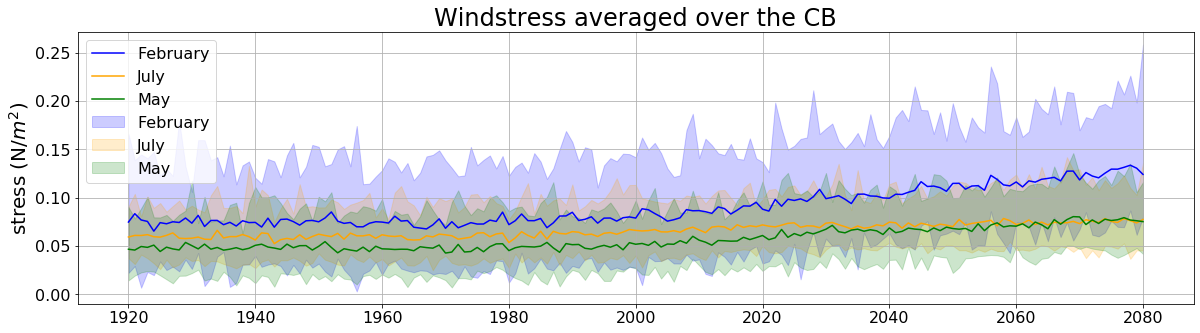

In [4]:
plt.figure(figsize=(20,5))
plt.plot(range(1920,2081),(list(TAUmean[0]['wind'])+list(TAUmean[1]['wind']))[1::12],label='February',color='blue')
plt.plot(range(1920,2081),(list(TAUmean[0]['wind'])+list(TAUmean[1]['wind']))[7::12],label='July',color='orange')
plt.fill_between(range(1920,2081),(list(TAUmin[0]['wind'])+list(TAUmin[1]['wind']))[1::12],
                 (list(TAUmax[0]['wind'])+list(TAUmax[1]['wind']))[1::12],label='February',color='blue',alpha=0.2)
plt.fill_between(range(1920,2081),(list(TAUmin[0]['wind'])+list(TAUmin[1]['wind']))[7::12],
                 (list(TAUmax[0]['wind'])+list(TAUmax[1]['wind']))[7::12],label='July',color='orange',alpha=0.2)
plt.plot(range(1920,2081),(list(TAUmean[0]['wind'])+list(TAUmean[1]['wind']))[4::12],label='May',color='green')
plt.fill_between(range(1920,2081),(list(TAUmin[0]['wind'])+list(TAUmin[1]['wind']))[4::12],
                 (list(TAUmax[0]['wind'])+list(TAUmax[1]['wind']))[4::12],label='May',color='green',alpha=0.2)

plt.legend()
plt.grid()
plt.ylabel('stress (N/$m^2$)')
plt.title("Windstress averaged over the CB")


Text(0.5, 1.0, 'ocean/ice stress averaged over the CB')

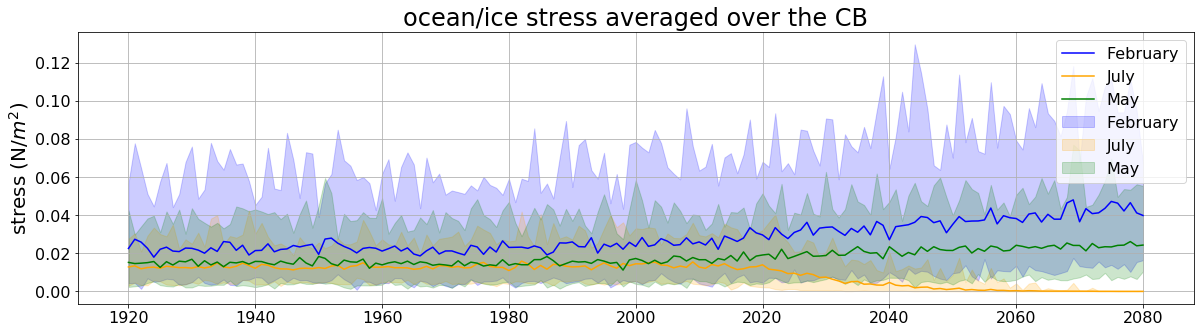

In [5]:
plt.figure(figsize=(20,5))
plt.plot(range(1920,2081),(list(TAUmean[0]['stro'])+list(TAUmean[1]['stro']))[1::12],label='February',color='blue')
plt.plot(range(1920,2081),(list(TAUmean[0]['stro'])+list(TAUmean[1]['stro']))[7::12],label='July',color='orange')
plt.fill_between(range(1920,2081),(list(TAUmin[0]['stro'])+list(TAUmin[1]['stro']))[1::12],
                 (list(TAUmax[0]['stro'])+list(TAUmax[1]['stro']))[1::12],label='February',color='blue',alpha=0.2)
plt.fill_between(range(1920,2081),(list(TAUmin[0]['stro'])+list(TAUmin[1]['stro']))[7::12],
                 (list(TAUmax[0]['stro'])+list(TAUmax[1]['stro']))[7::12],label='July',color='orange',alpha=0.2)
plt.plot(range(1920,2081),(list(TAUmean[0]['stro'])+list(TAUmean[1]['stro']))[4::12],label='May',color='green')
plt.fill_between(range(1920,2081),(list(TAUmin[0]['stro'])+list(TAUmin[1]['stro']))[4::12],
                 (list(TAUmax[0]['stro'])+list(TAUmax[1]['stro']))[4::12],label='May',color='green',alpha=0.2)

plt.legend()
plt.grid()
plt.ylabel('stress (N/$m^2$)')
plt.title("ocean/ice stress averaged over the CB")


(0, 0.08)

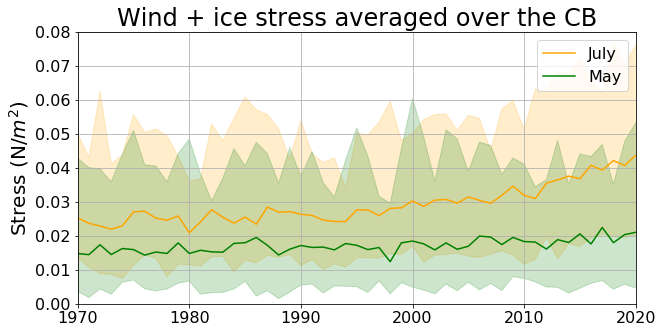

In [6]:
plt.figure(figsize=(10,5))
#plt.plot(range(1920,2081),(list(TAUmean[0]['TAU'])+list(TAUmean[1]['TAU']))[1::12],label='February',color='blue')
plt.plot(range(1920,2081),(list(TAUmean[0]['TAU'])+list(TAUmean[1]['TAU']))[7::12],label='July',color='orange')
#plt.fill_between(range(1920,2081),(list(TAUmin[0]['TAU'])+list(TAUmin[1]['TAU']))[1::12],
               #  (list(TAUmax[0]['TAU'])+list(TAUmax[1]['TAU']))[1::12],label='February',color='blue',alpha=0.2)
plt.fill_between(range(1920,2081),(list(TAUmin[0]['TAU'])+list(TAUmin[1]['TAU']))[7::12],
                 (list(TAUmax[0]['TAU'])+list(TAUmax[1]['TAU']))[7::12],color='orange',alpha=0.2)
plt.plot(range(1920,2081),(list(TAUmean[0]['TAU'])+list(TAUmean[1]['TAU']))[4::12],label='May',color='green')
plt.fill_between(range(1920,2081),(list(TAUmin[0]['TAU'])+list(TAUmin[1]['TAU']))[4::12],
                 (list(TAUmax[0]['TAU'])+list(TAUmax[1]['TAU']))[4::12],color='green',alpha=0.2)

plt.legend()
plt.grid()
plt.ylabel('Stress (N/$m^2$)')
plt.title("Wind + ice stress averaged over the CB")
plt.xlim(1970,2020)
plt.ylim(0,0.08)

In [4]:
tau70_per_month=np.array([tau_40[0]['TAU'][:,ind1970+m:ind1980+m:12] for m in range(12)])
print(tau70_per_month.shape)
tau70=np.nanmean(tau70_per_month, axis =2)
tau70year=np.nanmean(tau70, axis=0)
tau10_per_month=np.array([tau_40[1]['TAU'][:,ind2010+m:ind2020+m:12] for m in range(12)])
print(tau10_per_month.shape)
tau10=np.nanmean(tau10_per_month, axis =2)
tau10year=np.nanmean(tau10, axis=0)

(12, 40, 10)
(12, 40, 10)


(array([0.]), array([11.]))

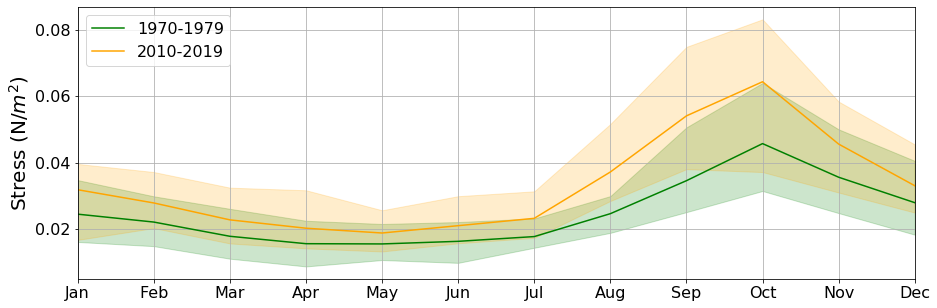

In [5]:
tau70max=np.nanmax(tau70,axis=1)
tau70min=np.nanmin(tau70,axis=1)
tau70mean=np.nanmean(tau70,axis=1)

tau10max=np.nanmax(tau10,axis=1)
tau10min=np.nanmin(tau10,axis=1)
tau10mean=np.nanmean(tau10,axis=1)

plt.figure(figsize=(15,5))
plt.plot(months,tau70mean, color='green',label='1970-1979')
plt.plot(months,tau10mean, color='orange',label='2010-2019')
plt.fill_between(months, tau70min,tau70max,color='green',alpha=0.2)
plt.fill_between(months, tau10min,tau10max,color='orange',alpha=0.2)
plt.legend(loc='upper left')
plt.ylabel('Stress (N/$m^2$)')
plt.grid()
plt.xlim(['Jan','Dec'])

In [7]:
tau10mean/tau70mean,np.mean([1.1824245,1.2998189, 1.2595922, 1.2766153, 1.2977691, 1.2111422])

(array([1.2998189, 1.2595922, 1.2766153, 1.2977691, 1.2111422, 1.2880205,
        1.3088744, 1.5084478, 1.5638498, 1.4067813, 1.279913 , 1.1824245],
       dtype=float32), 1.2545603666666667)